# Spectral Type Classification, Filter Curves and Colours with Python

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import os
import pandas as pd
from scipy.interpolate import splrep, splev

ROOT = os.path.dirname(os.path.realpath("__file__"))
PATH = '/Daten/'
BONUS = 'Bonusdaten/'
FILTER = 'Filterkurven/'
REF = 'Referenzspektren/'

Observed spectra, like observed images, are stored in FITS files (https://de.wikipedia.org/wiki/Flexible_Image_Transport_System). The [astropy project provides the FITS module](http://docs.astropy.org/en/stable/io/fits/index.html) for reading and writing FITS files in Python. 

In this exercise we will use the following Python packages:
* Astropy to read in spectra from FITS files 
* Matplotlib to display them on screen. 
* Numpy to manipulate the spectra.

The goal of this exercise is to use the Harvard classification system to determine the spectral type of 13 stars based on the strengths of several well-known absorption lines. We will also use the transmission curves for the B and V filter to derive the "colour" of the stars (optional task).

<div class="alert alert-block alert-info">
    When answering the questions that are not code or plots, try to work with "markdown" (normal text as this one here). We provided you with the cells labelled "<b>Answer</b>". You can "run" these cells with markdown formatting to get non-code text output.
</div>

# Part 1 - Plotting spectra in Python

## 1. The FITS file

All fits files use the ``Header-Data-Unit``, or HDU to store data. This can either be as tables (1D data), images (2D data) or data cubes (3D data). A single FITS files can contain several different HDUs and they can be mixed. For example, a FITS file may contain 4 images and 2 tables, each in separate HDUs. Hence when we open a FITS file, we must also know which HDU to look at to find the data we want.

### Opening
* Choose a file to open
* Use ``fits.open()`` to get a handle to the file

  To access different HDUs, use the ``[n]`` notation after the HDU variable name, where ``n`` is the HDU number we want


* Display the header of primary (i.e. ``[0]``) HDU in the file with the ``.header`` attribute
  
Look at the [astropy FITS module documentation](http://docs.astropy.org/en/stable/io/fits/index.html) if you need help.

If we were to simply ``open()`` the files, we would need to care about closing them again after we are done importing the data. To make our lives easier, we can use Python's ``with`` syntax, which automatically takes care of that. Inside the ``with`` block, we import the data to our internal variables, which we can use from that point on, without having to touch the original file again (unless we need to import from a different file of course).

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Complete the following code to load the file data into the <tt>header</tt> and <tt>data</tt> variables. You might need to try different HDUs, as escribed above, to get the correct data. Remember you can always use <tt>print(...)</tt> to take a look at what is stored in your variables!</p>
</div>

In [32]:
with fits.open(ROOT+PATH+'1.fits') as file:
    header = file[0].header
    data = file[0].data
print(header)

SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    1 / Number of axes                                 NAXIS1  =                 4771 / Axis length                                    ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 1999' / FITS file originator        EXTEND  =                    F / File may contain extensions                    DATE    = '2000-02-16T18:15:39' / Date FITS file was generated                  IRAF-TLM= '15:15:39 (16/02/2000)' / Time of last modification                   APNUM1  = '1 1     '                                                            WCSDIM  =                    1                                                  CTYPE1  = 'LINEAR  '                                                            CRVAL1  =                1150.                                                  CRPIX1  =                   1.          

### Axis information

First, we will take a look at the axis information. As you probably know, spectral data usually consists of wavelength on the x-axis and intensities (in various units) on the y-axis. In the data we are using here, there is no wavelength axis available, only information on how to construct it.

In the FITS header, we will usually find some info about the axis present in the file, somewhere close to the top. The first keyword you should be looking for is ``NAXIS``, which tells us the number of axis in the data (e.g. 1 for simple lists, 2 for images or multi-column tables, 3 for datacubes). According to this number, there will be ``n`` more keywords in the style of ``NAXIS1``, ``NAXIS2`` and so on, each telling us the length (=number of data points) on each axis.
We can accessing the values in these header fields via ``header["KEYWORD"]``.

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Take a look at the values and write a short interpretation of the numbers you see!</p>
</div>

**Answer:**
Short interpretation:
This FITS file describes a 1-dimensional spectrum with 4771 data points, starting at a wavelength of 1150.0 (Angstroms) and increasing linearly by 5 units per pixel. The data represents evenly spaced wavelengths or frequencies across a single spectral axis.


In [33]:
print("NAXIS:", header["NAXIS"])
print("NAXIS1:", header["NAXIS1"])
print("WCSDIM:", header["WCSDIM"])
print("CTYPE1:", header["CTYPE1"])
print("CRPIX1:", header["CRPIX1"])
print("CRVAL1:", header["CRVAL1"])
print("CDELT1:", header["CDELT1"])

NAXIS: 1
NAXIS1: 4771
WCSDIM: 1
CTYPE1: LINEAR
CRPIX1: 1.0
CRVAL1: 1150.0
CDELT1: 5.0


Next, let's look at the values which actually tell us how to construct our wavelength axis. In our data, this information is stored in the "WCS"-block of the header, which stands for "World Coordinate System". This is more commonly used for defining the coordinate axis of a 2D image, but in our case, it holds the information necessary to convert the position of the data points to wavelengths. The following keywords are useful:
* ``WCSDIM``...number of dimensions/axes of the "coordinate system"
* ``CTYPE1``...type of transformation used on axis 1
* ``CRPIX1``...reference pixel of axis 1, which has the value of:
* ``CRVAL1``...reference value of axis 1, in our case equivalent to the wavelength value of the reference (here = first) pixel $\lambda_0$ in Ångström.
* ``CDELT1``...step size of axis 1, in our case the wavelength intervals, or bin width, $\Delta\lambda$ in Ångström.

<div class="alert alert-block alert-warning">
    <h4>Questions</h4>
    <p>Again display those values from the header and try to answer the following questions with the information you now obtained:</p>
    <ol>
        <li>At what wavelength does the spectrum start?</li>
        <li>How many wavelength "bins" (number of data points) are there in the spectrum?</li>
        <li>What is the step between each bin?</li>
        <li>And using all those values, at what wavelength does the spectrum end?</li>
    </ol>
</div>

**Answer:** 

1. **At what wavelength does the spectrum start?**
   - The spectrum starts at **1150.0 Å** (from `CRVAL1`).

2. **How many wavelength "bins" (number of data points) are there in the spectrum?**
   - There are **4771 bins** (from `NAXIS1`).

3. **What is the step between each bin?**
   - The step between each bin is **5 Å** (from `CDELT1`).

4. **At what wavelength does the spectrum end?**
   - Using the starting wavelength, step size, and number of bins, the ending wavelength can be calculated as:
     
   End Wavelength = `CRVAL1` $ + $ (`NAXIS1` - 1) $\times $ `CDELT1` = $ 1150.0 + (4771 - 1) \times 5 = 25000.0 \, \text{Å}$
      - Therefore, the spectrum ends at **25000.0 Å**.



In [34]:
wavelength_end = header["CRVAL1"]+(header["NAXIS1"]-1)*header["CDELT1"]
print(wavelength_end)

25000.0


### Extract the data

The FITS file (or, to be precise, the HDU) contains the spectrum in the ``data`` property. Accessing this will return a Numpy Array, which can be used directly as your y-data. For the x-data, as stated above we need to construct it first. In the previous section, we obtained all necessary values to do this. What we want is an Array of equally spaced points, starting and ending at the wavelengths you determined above. For this, we can use ``np.arange()``, which is Numpy's Array-version of Python's standard ``range()`` function, which does just that! If you don't know the parameters that go into this function, you can type ``help(np.arange)`` to look it up.

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>We provided you with the beginning, now replace the <tt>...</tt> placeholders below to construct your axes!</p>
</div>

In [35]:
x = np.arange(header["CRVAL1"], wavelength_end + header["CDELT1"], header["CDELT1"])
y = data


You can now check if your two axes have the same length. If they don't, it is not possible to match $x$ and $y$ for each data point. 

In [36]:
print("x:", len(x))
print(f"y: {len(y)}")


x: 4771
y: 4771


## 2. Display the spectrum

### Basics of plotting

The most straightforward way to plot this kind of data is to simply use the matplotlib function ``plt.plot()``. Again, if you aren't familiar with the syntax, use ``help(plt.plot)``. Try it out and have a first look at the spectrum!

C:\Users\Julian\AppData\Local\Temp\ipykernel_24564\357714450.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim([yMin, yMax])
C:\Users\Julian\AppData\Local\Temp\ipykernel_24564\357714450.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax3.set_ylim([yMin, yMax])


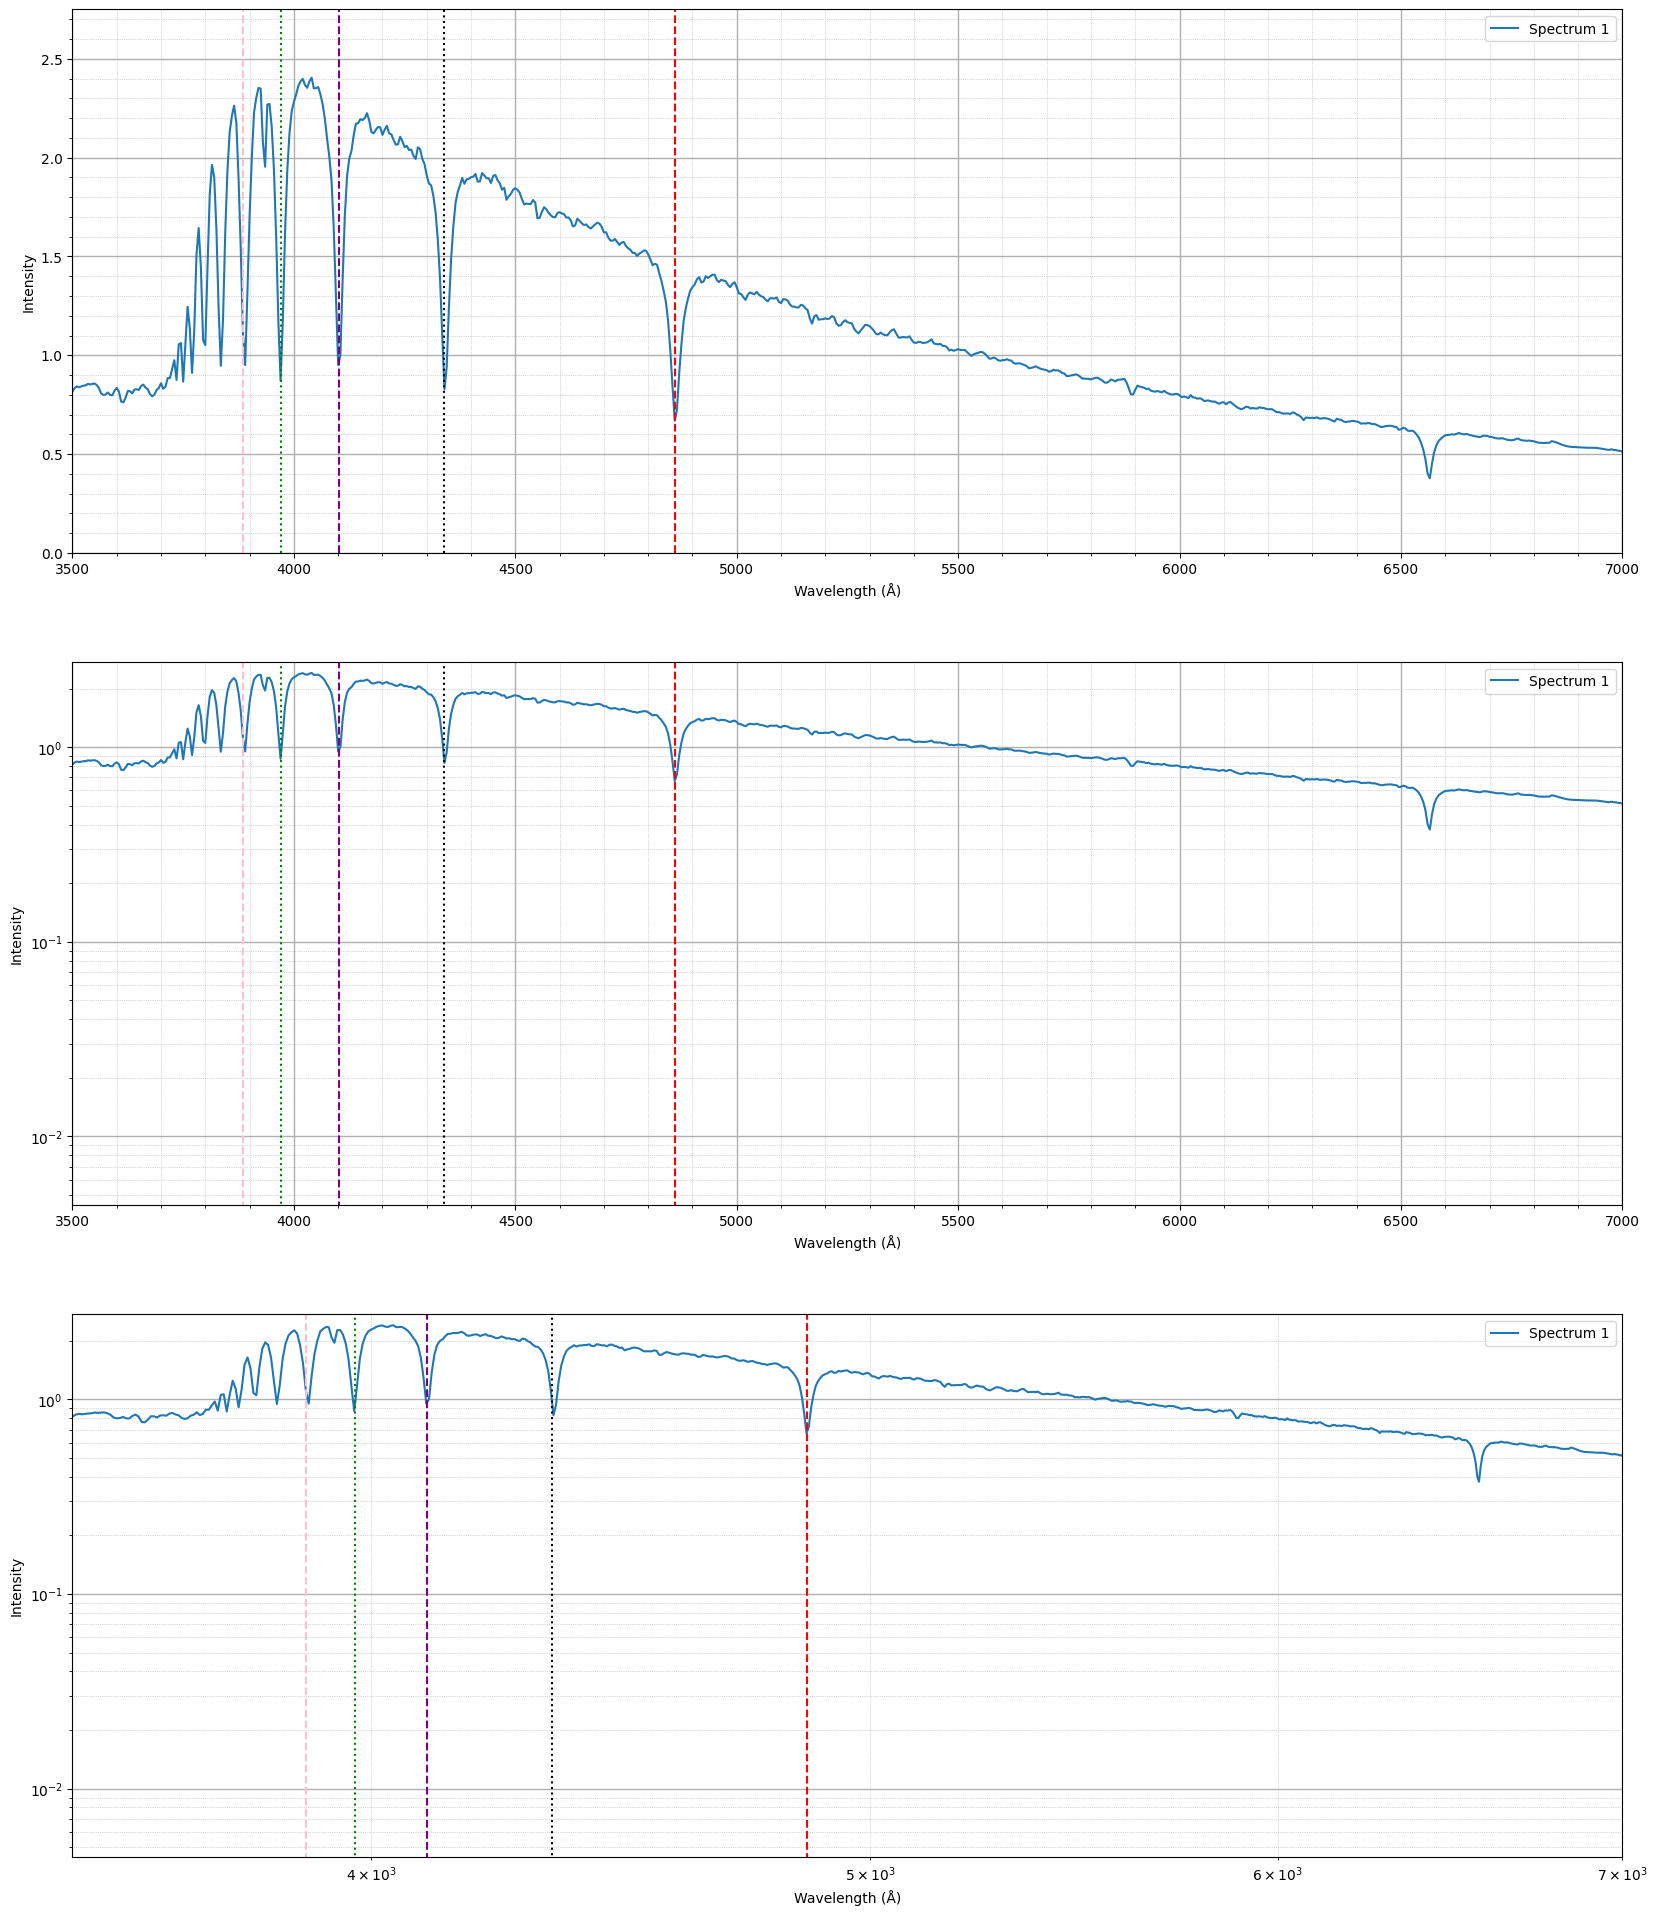

In [37]:
yMin = 0
yMax = 2.75

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(20, 24))
ax1.plot(x, y, label='Spectrum 1')
ax1.set_xlabel('Wavelength (Å)')
ax1.set_ylabel('Intensity')
ax1.set_xlim([3500, 7000])
ax1.set_ylim([yMin, yMax])
ax1.legend(loc='best')
ax1.minorticks_on()  
ax1.grid(visible=True, which='major', linestyle='-', linewidth=1)
ax1.grid(visible=True, which='minor', linestyle=':', linewidth=0.5)

ax1.vlines(4861, yMin, yMax, linestyles='dashed', colors='red', label='H-β Line')
ax1.vlines(4338, yMin, yMax, linestyles=':', colors='k', label='H-γ Line', linewidth=1.5)
ax1.vlines(4101, yMin, yMax, linestyles='dashed', colors='purple', label='H-δ Line', linewidth=1.5)
ax1.vlines(3971, yMin, yMax, linestyles=':', colors='green', label='H-ε Line', linewidth=1.5)
ax1.vlines(3885, yMin, yMax, linestyles='dashed', colors='pink', label='Neutral Metals', linewidth=1.5)


ax2.semilogy(x, y, label='Spectrum 1')
ax2.set_xlabel('Wavelength (Å)')
ax2.set_ylabel('Intensity')
ax2.set_xlim([3500, 7000])
ax2.set_ylim([yMin, yMax])
ax2.legend(loc='best')
ax2.minorticks_on()  
ax2.grid(visible=True, which='major', linestyle='-', linewidth=1)
ax2.grid(visible=True, which='minor', linestyle=':', linewidth=0.5)

ax2.vlines(4861, yMin, yMax, linestyles='dashed', colors='red', label='H-β Line')
ax2.vlines(4338, yMin, yMax, linestyles=':', colors='k', label='H-γ Line', linewidth=1.5)
ax2.vlines(4101, yMin, yMax, linestyles='dashed', colors='purple', label='H-δ Line', linewidth=1.5)
ax2.vlines(3971, yMin, yMax, linestyles=':', colors='green', label='H-ε Line', linewidth=1.5)
ax2.vlines(3885, yMin, yMax, linestyles='dashed', colors='pink', label='Neutral Metals', linewidth=1.5)


ax3.loglog(x, y, label='Spectrum 1')
ax3.set_xlabel('Wavelength (Å)')
ax3.set_ylabel('Intensity')
ax3.set_xlim([3500, 7000])
ax3.set_ylim([yMin, yMax])
ax3.legend(loc='best')
ax3.minorticks_on()  
ax3.grid(visible=True, which='major', linestyle='-', linewidth=1)
ax3.grid(visible=True, which='minor', linestyle=':', linewidth=0.5)

ax3.vlines(4861, yMin, yMax, linestyles='dashed', colors='red', label='H-β Line')
ax3.vlines(4338, yMin, yMax, linestyles=':', colors='k', label='H-γ Line', linewidth=1.5)
ax3.vlines(4101, yMin, yMax, linestyles='dashed', colors='purple', label='H-δ Line', linewidth=1.5)
ax3.vlines(3971, yMin, yMax, linestyles=':', colors='green', label='H-ε Line', linewidth=1.5)
ax3.vlines(3885, yMin, yMax, linestyles='dashed', colors='pink', label='Neutral Metals', linewidth=1.5)



You can also display different regions of the spectrum by setting the limits of the x-axis using ``plt.xlim()``.

If you want logarithmic axes, use ``plt.semilogy()``, ``plt.semilogx()`` or ``plt.loglog()``.

<div class="alert alert-block alert-warning">
    <h4>Question</h4>
    <p>Discuss the pros and cons of logarithmic plots, both in general and in particular for the spectra we're using. What is the best option in this case and why? Decide for one (plot, semilog or loglog), give a reasoning for your choice and <strong>stick with it for all plots in this exercise for consistency!</strong></p>
</div>

**Answer:**

For very large datasets, that stretch over more orders of magnitude or scale exponential, the logarithmic scaling often is more comfortalbe to get relatively small plots.
This comes from the fact, that log-scalings somewhat linearize non-linear data when plotted.
Linear scalings in such cases, may stretch too far to show everything on the same range without dropping details.

The biggest flaw of log-scales is the readablility.
Through the fact, that every bigger marker on the axis equals a factor of 10, reading data can be irritationg sometimes.
On linear scales on the other hand, the major intersections are additive plus 10 on the data, wich is more intuitive.


For our data a semilog-scaling on the y-axis would still work, but look squished to the top, like to see in the example plot above. This sqish results from exactly this linearization of the data through the log-scaling. Double-logarithmic doesn't make a big difference to the semi-log plot. It just looks a bit more stretched along the x-axis.
For the spectra in this exercise we decided to stick with linear scalings, through the fact, that our data stays within one order of magnitude and that we wanted to keep an intuitive data readout. Meaning, having the peaks in absolute, not relative sizes to each others.



### Analysing the plot

You are now in a position to start analysing the plotted spectrum. To zoom in on different parts, use ``plt.xlim()`` as discussed before.

<div class="alert alert-block alert-warning">
    <h4>Questions</h4>
    <p>Try to answer the following questions using your plot. You might need to look up wavelengths of prominent absorption lines or use the pdf files provided in Moodle:</p>
    <ol>
        <li>Is the spectrum normalised or not? How can you tell?</li>
        <li>At what wavelength is the peak (highest value) of the spectrum? Note that the data is likely noisy, so try to estimate the actual peak (by eye), don't just take the highest pixel if it doesn't fit.</li>
        <li>At what wavelengths are the strongest absorption features (spectral lines) in this spectrum? Make a list of the wavelengths for the 5 strongest features and note the relative depth of each feature and try to guess the element which might have produced each line! In the "Comments" column, you can add general remarks of the absorption feature.</li>
        <li>What could these elements tell us about the star? Hot/Cold? Young/old? Something else?</li>
        <li>What is happening around 3800 Å (if anything, not every spectrum has that feature (why?))?</li>
    </ol>
</div>

_The relative depth is a measurement of how far an absorption line dips down from the continuum. For example, a line with a minimum very close to the x-axis might have a relative depth close to .9 or 90 %, whereas a line that only goes half the way from the continuum to the bottom will have a relative depth of around .5 or 50 %._

**Answer:**

1. **Is the spectrum normalised or not? How can you tell?**
   - The spectrum does not appear to be normalized. In a normalized spectrum, the continuum level would be adjusted to a constant value, here the intensity varies across the wavelength range.

2. **At what wavelength is the peak (highest value) of the spectrum?**
    - The peak seems to be around 4050Å, which corresponds to intensity of around 2.4.

3.

| Wavelength [Å]  | Absorption Feature   | Element        | Comments |
|-----------------|----------------------|----------------|----------|
|      3885       |          60%         |   Neutral Metals (G-Band) |    associated with Methylidyne absorption, common in cooler stars      |
|      3971       |          60%         |      Hε      |    part of the Balmer series      |
|      4101       |          60%         |      Hδ      |    another Balmer line, hot stars |
|      4338       |          60%         |      Hγ      |    another Balmer line      |
|      4861       |          55%         |      Hβ      |    a key Balmer line for identifying spectral type      |



4. **What could these elements tell us about the star? Hot/Cold? Young/old? Something else?**
    - The spectrum suggests the star is a hot, young, main-sequence star, likely of A or early F type (temperature ~7,000–10,000 K). The strong Balmer lines and G-band absorption indicate moderate metallicity and a relatively early evolutionary stage.

5. **What is happening around 3800 Å (if anything, not every spectrum has that feature (why?))?**
    - Around 3800 Å, the chosen stellar spectrum is showing wild peaks or jumps that are due to the Balmer discontinuity (a.k.a. Balmer jump) from increased hydrogen absorption. This feature doesn't appear in all spectra because its presence depends on the star's temperature and atmospheric conditions.

## 3. Classify the star using the Harvard (-Yerkes) scheme

The next step is to classify the provided spectra using the well-known Harvard (-Yerkes) scheme, i.e. the OBAFGKM spectral classes.

The important lines in this classification scheme are: the Balmer Lines (esp. H beta, delta and epsilon), Calcium H+K doublet, Calcium G line, the Sodium doublet and the Helium lines. Slightly different variants of this scheme exist, we provided you with a rather simple one using less different lines, which you can find as a pdf file on Moodle ("Spektralklassifizierung Flowchart").

In this flowchart, you start at the top left and in each step decide if the spectrum exhibits the characteristics in question. A line counts as "being present" if it is clearly distinguishable from the background noise of the continuum. The meaning of the central lower decision ("Ca H & K <=> H epsilon & delta") is whether the Ca H & K lines (which will usually be about equally strong/deep) are less (<), roughly equal (=) ore more (>) strong/deep than the average of the Balmer lines H epsilon and H delta.

As stated in the flowchart, the "official" distinction between spectral types K and M is not really visibly in our data. There are however other ways to tell these classes apart, try to figure out how! All the borders between spectral classes are of course blurred, so you can use the subclasses denoted with arabic numericals 0-9 to achieve a better classification, or when you think a star seems to be "in between" two classes. Try to give an explanation of how "fine grained" of a subclass is even meaningful to use in the context of this exercise!

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Plot all of the spectra and classify them by the Harvard (-Yerkes) OBAFGKM scheme. Be sure to include a reasoning for your decisions (i.e. <i>why</i> did you classify star X as class Y). Try to include markers in your plots denoting the lines used in the classification.</p>
</div>

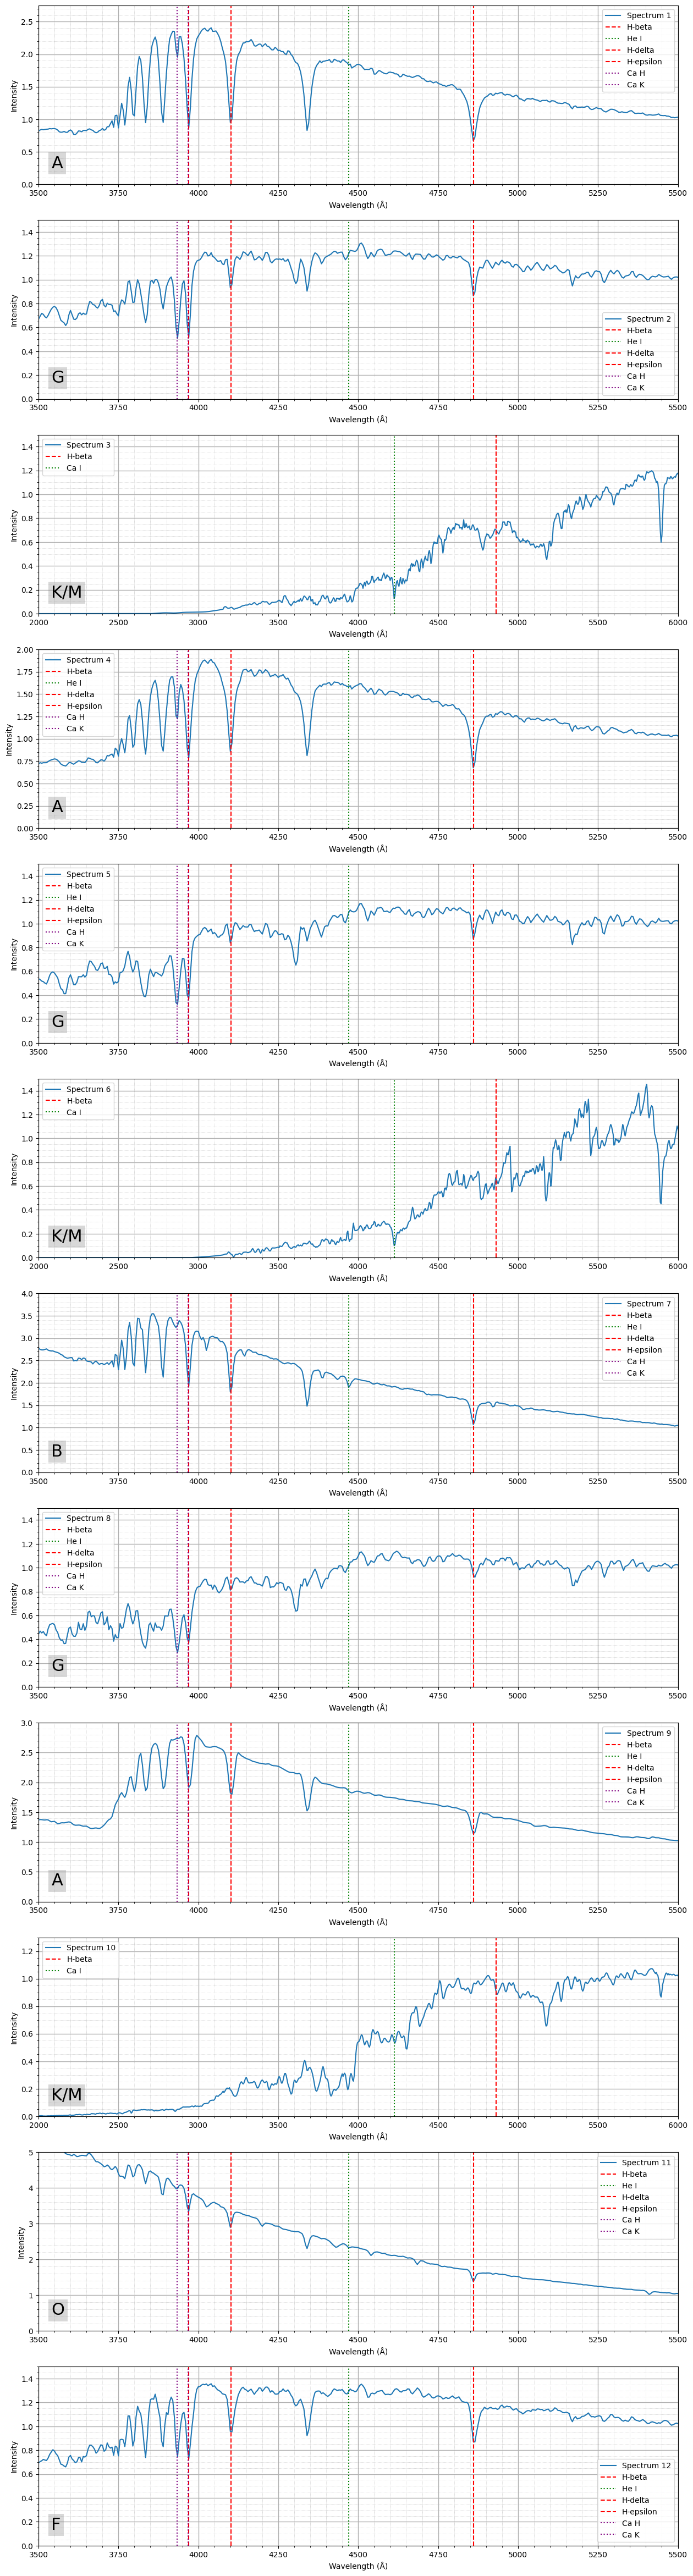

In [38]:
#Calc end of Wave-Band
def calcRangeEnd(head):
    return head["CRVAL1"]+(head["NAXIS1"]-1)*head["CDELT1"]

#calc X Axis
def calcXVals(header):
    return np.arange(header["CRVAL1"], calcRangeEnd(header) + header["CDELT1"], header["CDELT1"])


#Fetch Data-Files
files = [file for file in os.listdir(ROOT+PATH) if file.endswith('fits')]

#Split Filenames for Sorting and def Sorting-Frame
tempArr = []
for file in files:
    nr = file.split('.')[0]
    if file.endswith('fits') == True:
        tempArr.append(int(nr))
    else:
        tempArr.append(None)

#Lookup DF Nr-File
fileFrame = pd.DataFrame({'Nr': tempArr, 'Files': files})
fileFrame.sort_values(['Nr', 'Files'], inplace=True)

#Fetch Data
def openFit(fileName):
    with fits.open(ROOT+PATH+fileName) as fit:
        header = fit[0].header
        data = fit[0].data.flatten()
    return (header, data)

#Extract Header and Data from Files and prep plotable axis
Headers = pd.DataFrame(columns=['Nr', 'Header'])
Spectra = pd.DataFrame(columns=['Nr', 'Data'])
Axes = pd.DataFrame(columns=['X', 'Y'])

for idx, row in fileFrame.iterrows():
    nr = row['Nr']
    file = row['Files']
    fitData = openFit(file)

    Headers.loc[len(Headers)] = [nr, fitData[0]]
    Spectra.loc[len(Spectra)] = [nr, fitData[1]]
    Axes.loc[len(Axes)] = [calcXVals(fitData[0]), fitData[1]]

def plotSpectra(x, y, ax=None, nr=None, xLim=[], yLim=[], emmLines=[]):
    ax.plot(x, y, label=f'Spectrum {nr+1}')
    ax.minorticks_on()  
    ax.grid(visible=True, which='major', linestyle='-', linewidth=1)
    ax.grid(visible=True, which='minor', linestyle=':', linewidth=0.5)

    for line in emmLines:
        match line:
            case 'H-beta':
                ax.vlines(4861, yLim[0], yLim[1], linestyles='dashed', colors='red', label='H-beta')
            case 'He I':
                ax.vlines(4471, yLim[0], yLim[1], linestyles=':', colors='green', label='He I')
            case 'H-delta':
                ax.vlines(4102, yLim[0], yLim[1], linestyles='dashed', colors='red', label='H-delta')
            case 'H-epsilon':
                ax.vlines(3970, yLim[0], yLim[1], linestyles='dashed', colors='red', label='H-epsilon')
            case 'Ca H':
                ax.vlines(3968.5, yLim[0], yLim[1], linestyles=':', colors='purple', label='Ca H')
            case 'Ca K':
                ax.vlines(3933.7, yLim[0], yLim[1], linestyles=':', colors='purple', label='Ca K')
            case 'Ca I':
                ax.vlines(4226, yLim[0], yLim[1], linestyles=':', colors='green', label='Ca I')

    ax.set_xlim(xLim)
    ax.set_ylim(yLim)
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Intensity')
    ax.legend(loc='best')
    return ax

xScalings = [[3500, 5500]
              ,[3500, 5500]
              ,[2000, 6000]
              ,[3500, 5500]
              ,[3500, 5500]
              ,[2000, 6000]
              ,[3500, 5500]
              ,[3500, 5500]
              ,[3500, 5500]
              ,[2000, 6000]
              ,[3500, 5500]
              ,[3500, 5500]]

yScalings = [[0, 2.75]
             ,[0, 1.5]
             ,[0, 1.5]
             ,[0, 2]
             ,[0, 1.5]
             ,[0, 1.5]
             ,[0, 4]
             ,[0, 1.5]
             ,[0, 3]
             ,[0, 1.3]
             ,[0, 5]
             ,[0, 1.5]]

emissionLines = [['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta', 'Ca I']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta', 'Ca I']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta', 'Ca I']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']
                 ,['H-beta', 'He I', 'H-delta', 'H-epsilon', 'Ca H', 'Ca K']]

spectral_classes = {
    0: 'A',
    1: 'G',
    2: 'K/M',
    3: 'A',
    4: 'G',
    5: 'K/M',
    6: 'B',
    7: 'G',
    8: 'A',
    9: 'K/M',
    10: 'O',
    11: 'F'}

fig, axes = plt.subplots(12, 1, figsize=(15, 60))
for idx, row in Axes.iterrows():
    plotSpectra(row['X'], row['Y'], ax=axes[idx], nr=idx, xLim=xScalings[idx], yLim=yScalings[idx], emmLines=emissionLines[idx])
    
    spectral_class = spectral_classes.get(idx, '')
    if spectral_class:
        x_pos = xScalings[idx][0] + 0.02 * (xScalings[idx][1] - xScalings[idx][0])
        y_pos = yScalings[idx][0] + 0.09 * (yScalings[idx][1] - yScalings[idx][0])
    axes[idx].text(x_pos, y_pos, spectral_class, fontsize=22, color='black', bbox=dict(facecolor='grey', alpha=0.3, edgecolor='none'))

plt.show()


**Classification of spectra using Harvard (-Yerkes) scheme:**

Observations and decision criteria for the different spectra based on the provided simple classification scheme including the final classification of the stars are shown in the following table:  

| Spectrum |   clear Hβ line?    |     He I line present?    | CaH/CaK vs Hε/Hδ | continuum increasing? | Classification |
|:--------:|:-------------------:|:-------------------------:|:----------------:|:---------------------:|:--------------:|
|    1     |    yes              |      no                   |       <          |                       |       A        |
|    2     |    yes              |      no                   |       >          |                       |       G        |
|    3     |    no               |      -                    |       -          |          no           |      K/M       |
|    4     |    yes              |      no                   |       <          |                       |       A        |
|    5     |    yes              |      no                   |       >          |                       |       G        |
|    6     |    no               |      -                    |       -          |          no           |      K/M       |
|    7     |    yes              |      yes                  |       -          |                       |       B        |
|    8     |    yes              |      no                   |       >          |                       |       G        |
|    9     |    yes              |      no                   |       <          |                       |       A        |
|   10     |    no               |      -                    |       -          |          no           |      K/M       |
|   11     |    no               |      -                    |       -          |          yes          |       O        |
|   12     |    yes              |      no                   |       =          |                       |       F        |

Remark: Spectra 7 and 11 show high fluxes at wavelengths lower than Balmer jump indicating Stars of high temperature (O, B).

Remark: Spectrum 9 was classified as A star because of missing He I line and dominant Hε/Hδ lines. But the overall spectrum is similar to spectrum 7 and therefore also shows high flux at lower wavelengths. So the star is more likely a B star like number 7. Additionally the spectrum differs significally from the spectra of the other two class A stars (1, 4).

One way to distinguish K and M stars without using the usual TiO band features of M stars is to make use of the metallic absorption features of K stars like iron (Fe), calcium (Ca) and sodium (Na). These metallic absorption features are less/not present in M class stars because of their lower temperature.

Remark: Spectra 3 and 6 show an clear absorption feature at ~4225 Å indicating a Ca I absorption line (4226 Å) there. So both these stars would therefore be K stars and spectrum 10 would be a M star then.



<div class="alert alert-block alert-warning">
    <h4>Further theoretical Questions</h4>
    <p>Why do strong Balmer lines mean we are looking at hotter stars? What could be happening in the stars' atmosphere to cause the Calcium H+K and Calcium G lines to be strongest in solar type (F, G) stars?</p>
</div>

**Answer:**

In hotter stars, around 10.000K (A-Type e.g.) tend to have stronger balmer lines. This results in the fact, that those high temperatures are able to excite the hydrogen of the star into higher energetic states and on more frequent rate than the colder types.

The Ca II H & K lines shapes represent the chromospheric activity of F- and G-type stars. The peak of those lines correlates with the temperature of the stars atmosphere.
This was showed by studies done with the HARPS-N spectra (https://academic.oup.com/mnras/article/527/2/2940/7332933).
The high occurence of those lines furthermore results in the high metalicity of those old generation stars.



## 4. Luminosity class

If all stars were main sequence stars, the Harvard system would be enough to get a rough idea of what type of star we are looking at. However, stars change as they age. They evolve from main sequence stars to giant stars and thus their luminosity increases. Therefore, an extension to the classification system is used, the luminosity class, denoted with roman numericals. One way to determine whether a star is a main sequence (luminosity class V) or a giant (class I to III) is to look at its spectrum. We provided you with two additional spectra, which only differ in luminosity class (V and I), but have the same spectral class (A0).

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Open the following two files and plot their spectra in a single plot:</p>
    <ul>
        <li><tt>a0v.fits</tt></li>
        <li><tt>a0i.fits</tt></li>
    </ul>
</div>

<Axes: xlabel='Wavelength (Å)', ylabel='Intensity'>

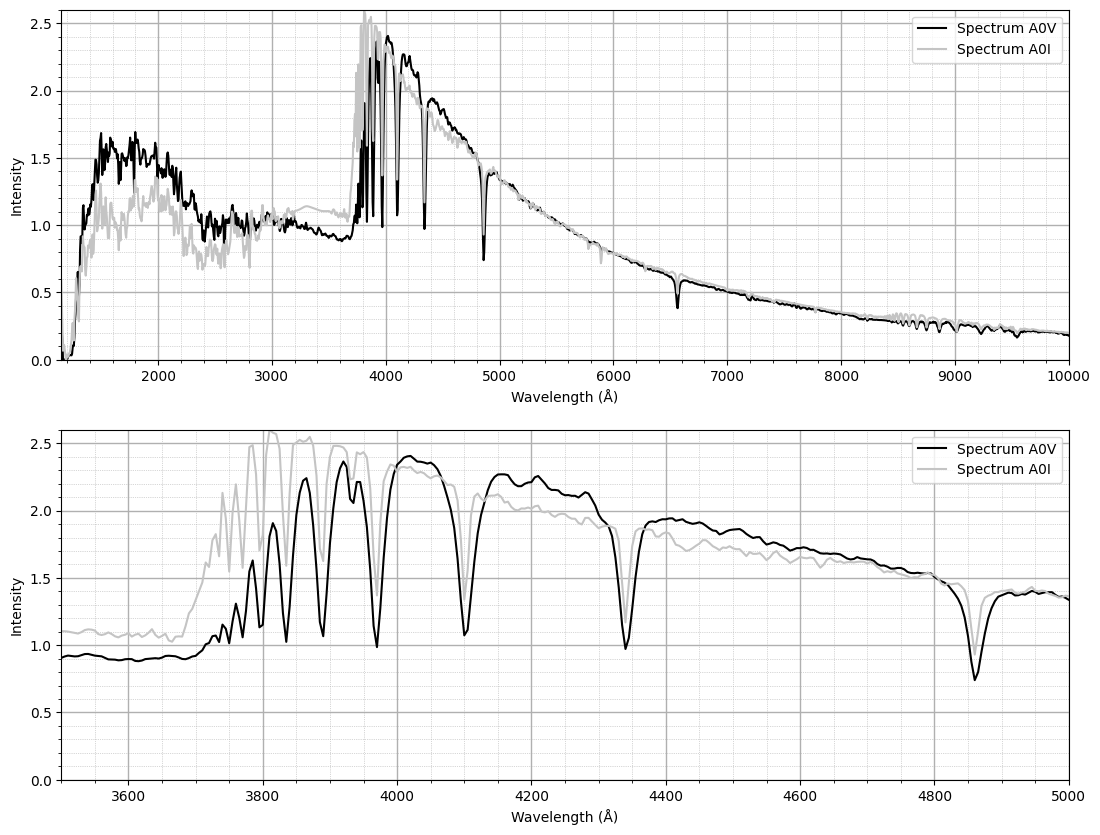

In [39]:
with fits.open(ROOT+PATH+REF+'a0i.fits') as file:
    header_a0i = file[0].header
    data_a0i = file[0].data

x_a0i = np.arange(header_a0i["CRVAL1"], calcRangeEnd(header_a0i) + header_a0i["CDELT1"], header_a0i["CDELT1"])
y_a0i = data_a0i

with fits.open(ROOT+PATH+REF+'a0v.fits') as file:
    header_a0v = file[0].header
    data_a0v = file[0].data

x_a0v = np.arange(header_a0v["CRVAL1"], calcRangeEnd(header_a0v) + header_a0v["CDELT1"], header_a0v["CDELT1"])
y_a0v = data_a0v

def plotRefSpectra(valsV, valsI, ax=None, xLim=[], yLim=[]):
    ax.plot(valsV[0], valsV[1], label='Spectrum A0V', linestyle='-', c='k')
    ax.plot(valsI[0], valsI[1], label='Spectrum A0I', linestyle='-', c='#C4C4C4')
    #ax.plot(Axes['X'][3], Axes['Y'][3], label='Spectrum 4', c='b')
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Intensity')
    ax.set_xlim(xLim)
    ax.set_ylim(yLim)
    ax.grid(True)
    ax.minorticks_on()  
    ax.grid(visible=True, which='major', linestyle='-', linewidth=1)
    ax.grid(visible=True, which='minor', linestyle=':', linewidth=0.5)
    ax.legend()
    return ax


fig, axes = plt.subplots(2, 1, figsize=(13, 10))
plotRefSpectra([x_a0v, y_a0v], [x_a0i, y_a0i], ax=axes[0], xLim=[1150, 10000], yLim=[0, np.max(y_a0i)])
plotRefSpectra([x_a0v, y_a0v], [x_a0i, y_a0i], ax=axes[1], xLim=[3500, 5000], yLim=[0, np.max(y_a0i)])

<div class="alert alert-block alert-warning">
    <h4>Questions</h4>
    <p>What differences do you note between the spectra? What is the difference between the two stars, based on their classification (A0V and A0I)? Which of the following parameters are different, which are (roughly) the same and why: temperature, age, radius, mass, luminosity?</p>
</div>

**Answer:**
### 1. Spectral Differences Observed

- **Hydrogen Balmer Lines:**
  - **A0V (Main-Sequence (Dwarf)):** 
    - Broader wings (dips) due to higher surface gravity and interplay of the Stark effect, the dominant broadening mechanism. Overall more extended and broadened spectral lines.
  - **A0I (Supergiant):**
    - Sharper and more defined spectral lines. Resulting from lower surface gravity and weaker Stark broadening (effect).
### 2. Classification Differences (A0V vs. A0I)

- **A0V:**
  - Luminosity Class V
  - Evolutionary Stage: Hydrogen-burning phase, stable and relatively young.
  - Surface Gravity: High
  - Atmospheric Density: High, leading to broader hydrogen lines.

- **A0I:**
  - Luminosity Class I
  - Evolutionary Stage: Advanced stage, post-hydrogen-burning, expanded and evolved.
  - Surface Gravity: Low
  - Atmospheric Density: Low, resulting in narrower hydrogen lines.

## 3. Comparison of Stellar Parameters

| Parameter    | A0V  (Main-Sequence)        | A0I (Supergiant)    | Reasoning                                              |
|--------------|----------------------|-----------------------|--------------------------------------------------------|
| **Temperature** | **Similar** (~10,000 K) | **Similar** (~10,000 K) | Same spectral type indicates similar surface temperatures. |
| **Age**        | **Younger**           | **Older**             | A0V are in an earlier evolutionary stage; A0I are evolved. |
| **Radius**     | **Smaller**           | **Much Larger**       | Supergiants have expanded radii compared to dwarfs.      |
| **Mass**       | **Lower to Moderate** | **Higher**            | Supergiants originate from more massive precursors.    |
| **Luminosity** | **Lower**             | **Much Higher**       | Larger radius and higher energy output in supergiants.  |

Comment: The differing spectra of A0V and A0I stars around 3600–4000 Å are primarily due to variations in surface gravity, which affect line broadening and ionization states (Mihalas, 1978).



<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Using the information from those two spectra (i.e. their differences), try to classify the previous spectra in terms of their luminosity classes. Now because we only have the example spectra for A-type stars here, it is sufficient to do this only for those stars which you previously classified as B, A or F. Any other spectral type is too different altogehter to allow any meaningful determination of luminosity class based on an A0I/A0V example.</p>
</div>

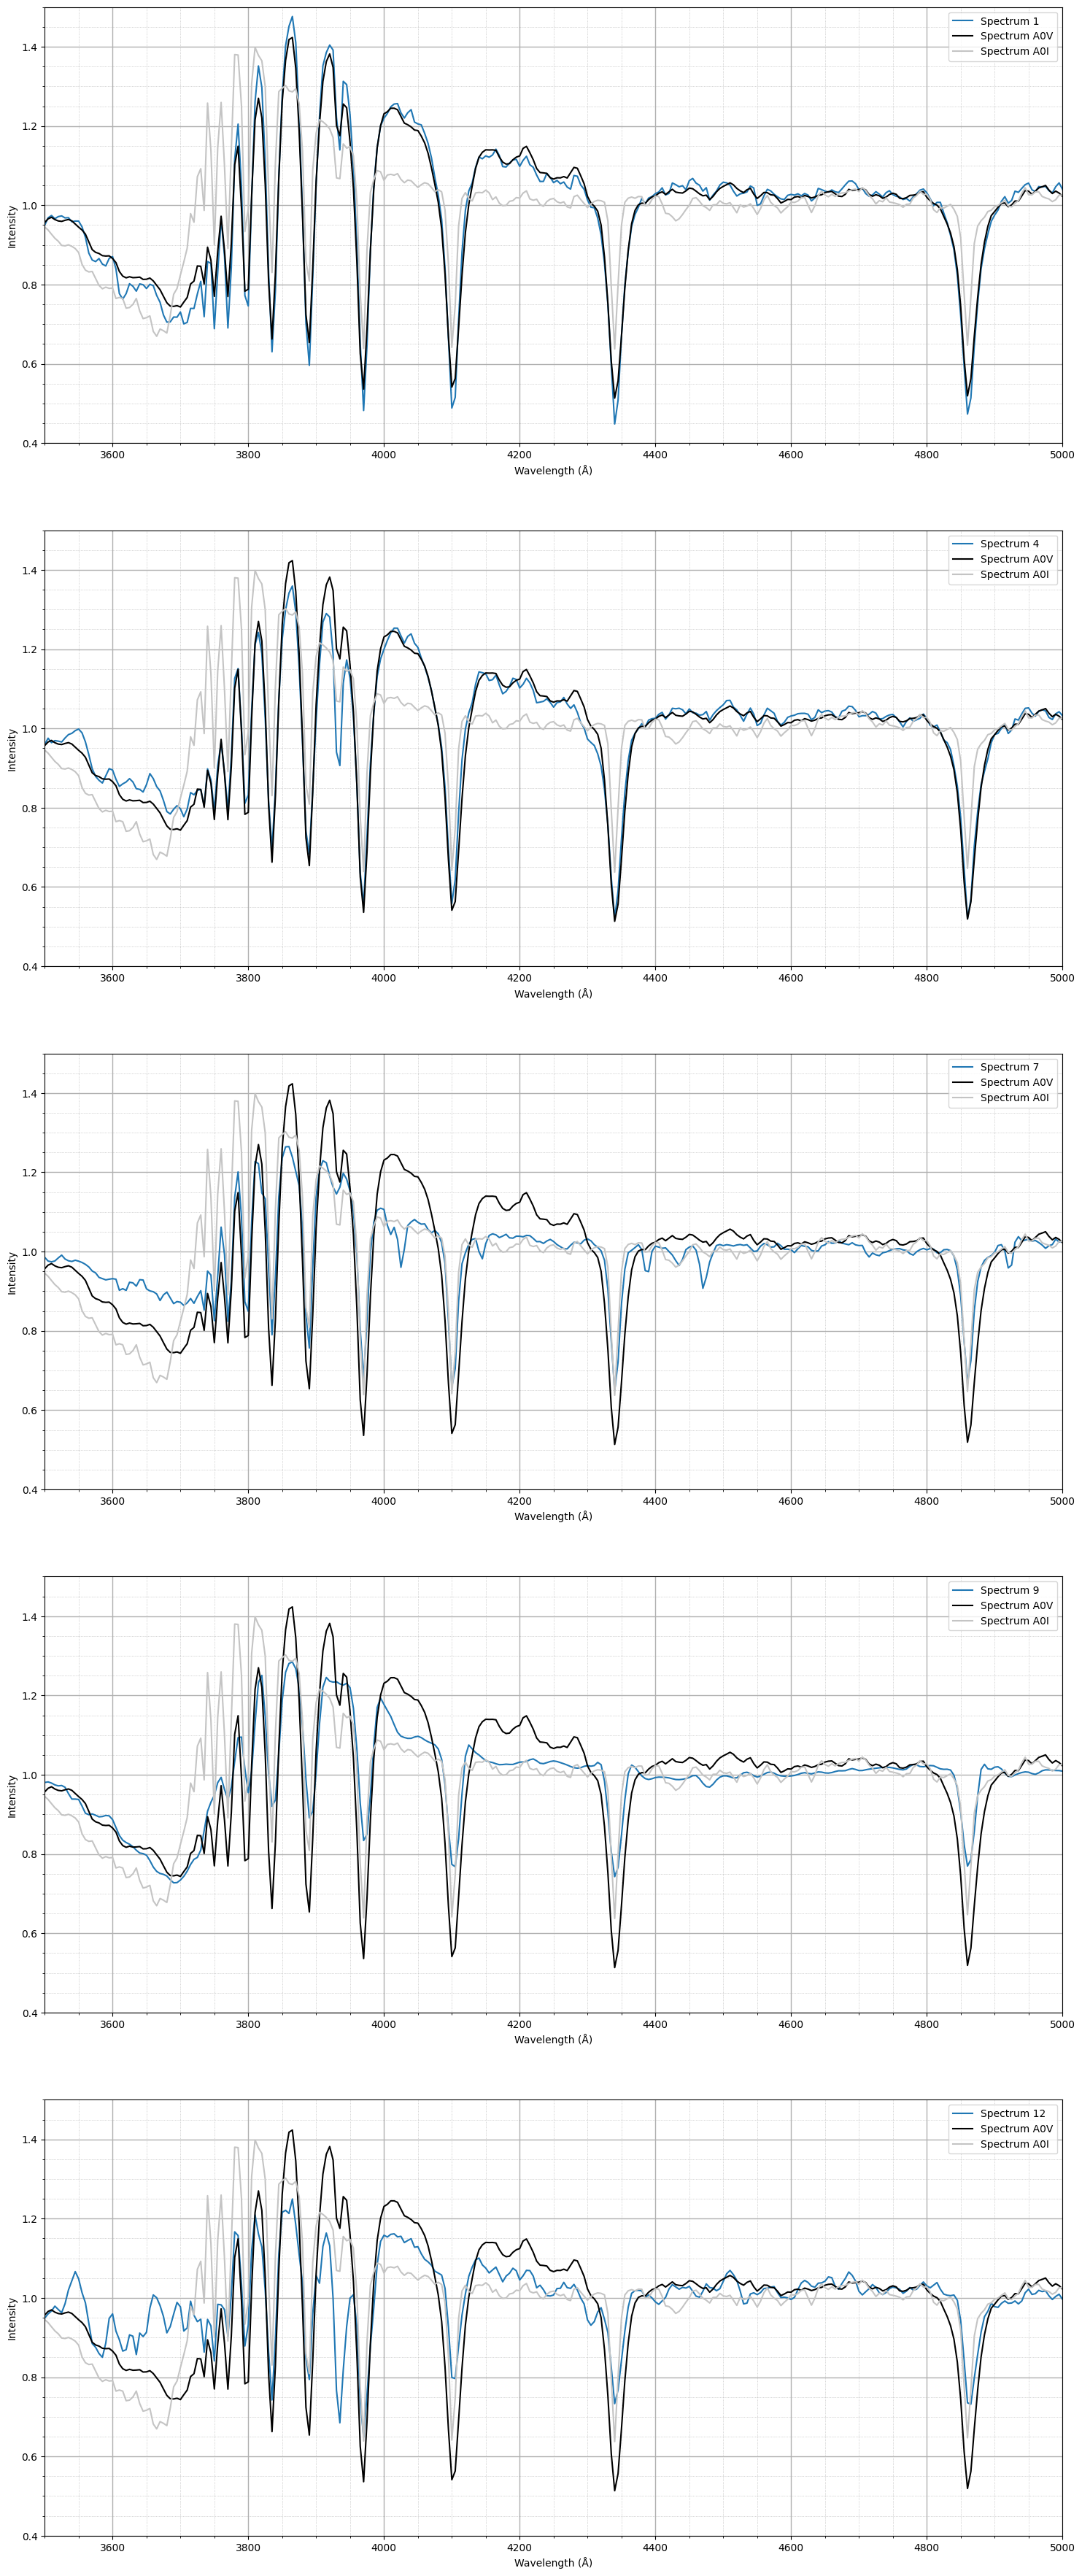

In [40]:
def normalized_spectrum(data, window):
    half_window = window // 2
    normalized_spectrum = np.zeros_like(data)
    for i in range(len(data)):
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)
        local_mean = np.mean(data[start:end])
        normalized_spectrum[i] = data[i] / local_mean
    return normalized_spectrum

window_size = 100

def plotSpectra(x, y, ax=None, nr=None, xLim=[], yLim=[], scale=1):
    ax.plot(x, y*scale, label=f'Spectrum {nr+1}')
    ax.minorticks_on()  
    ax.grid(visible=True, which='major', linestyle='-', linewidth=1)
    ax.grid(visible=True, which='minor', linestyle=':', linewidth=0.5)
    return ax

xScalings = [[3500, 5500]
              ,[3500, 5500]
              ,[3500, 5000]
              ,[3500, 5500]
              ,[3500, 5500]
              ,[3500, 5000]
              ,[3500, 5000]
              ,[3500, 5500]
              ,[3500, 5500]
              ,[3500, 5000]
              ,[3500, 5500]
              ,[3500, 5500]]

yScalings = [[0.4, 1.5]
             ,[0.4, 1.5]
             ,[0.4, 1.5]
             ,[0.4, 1.5]
             ,[0.4, 1.5]
             ,[0.4, 1.5]
             ,[0.4, 1.5]
             ,[0.4, 1.5]
             ,[0.4, 1.5]
             ,[0.4, 1.5]
             ,[0.4, 1.5]
             ,[0.4, 1.5]]


spectral_classes = {
    0: 'A',
    1: 'G',
    2: 'KM',
    3: 'A',
    4: 'G',
    5: 'KM',
    6: 'B',
    7: 'G',
    8: 'A',
    9: 'KM',
    10: 'O',
    11: 'F'}

scale = [ 1
        ,1
        ,1
        ,1
        ,1
        ,1
        ,1
        ,1
        ,1
        ,1
        ,1
        ,1]


y_a0v_normalized = normalized_spectrum(y_a0v, window_size)
y_a0i_normalized = normalized_spectrum(y_a0i, window_size)

fig, axes = plt.subplots(5, 1, figsize=(18, 45))
cnt = 0
for idx, row in Axes.iterrows():
    if (spectral_classes.get(idx) == 'A') or (spectral_classes.get(idx) == 'B') or (spectral_classes.get(idx) == 'F'):
        plotSpectra(row['X'], normalized_spectrum(row['Y'], window_size), ax=axes[cnt], nr=idx, xLim=xScalings[idx], yLim=yScalings[idx], scale=scale[idx])
        plotRefSpectra([x_a0v, y_a0v_normalized], [x_a0i, y_a0i_normalized], ax=axes[cnt], xLim=[3500, 5000], yLim=[0.4, 1.5])
        cnt +=1

plt.show()

| Spectrum |   Spectral classification    |     Luminosity class     |
|:--------:|:----------------------------:|:------------------------:|
|    1     |            A                 |          V               |
|    4     |            A                 |          V               |
|    7     |            B                 |          I               |
|    9     |            A                 |          I               |
|   12     |            F                 |          I               |

## 5. Spectrophotometry

To get a rough estimation of a star's colour, we can look at the flux of the spectrum in certain wavelength bands, which correspond to photometric filters. Since these filters are not perfect rectangles, but have a transmission curve, we provided you with approximate values for transmission at certain wavelength intervals for three of the most important filters, B, V and R.

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>You can use these filter curves to obtain the total (integrated) flux in the three filters for each star. By comparing the B, V and R values, you can calculate a "colour" for the star. Because the wavelength axis of the filter files is not the same as that of the spectra, you'll need to perform an interpolation of the filter curves using e.g. an appropriate numpy function.</p>
</div>

For Spectrum 1(A): 
 B-V: -0.6491210219521654 
 V-R: 0.09436352272007703 

 for Spectrum 3(KM): 
 B-V: 0.6968621488293852 
 V-R: 0.9202993451766759 


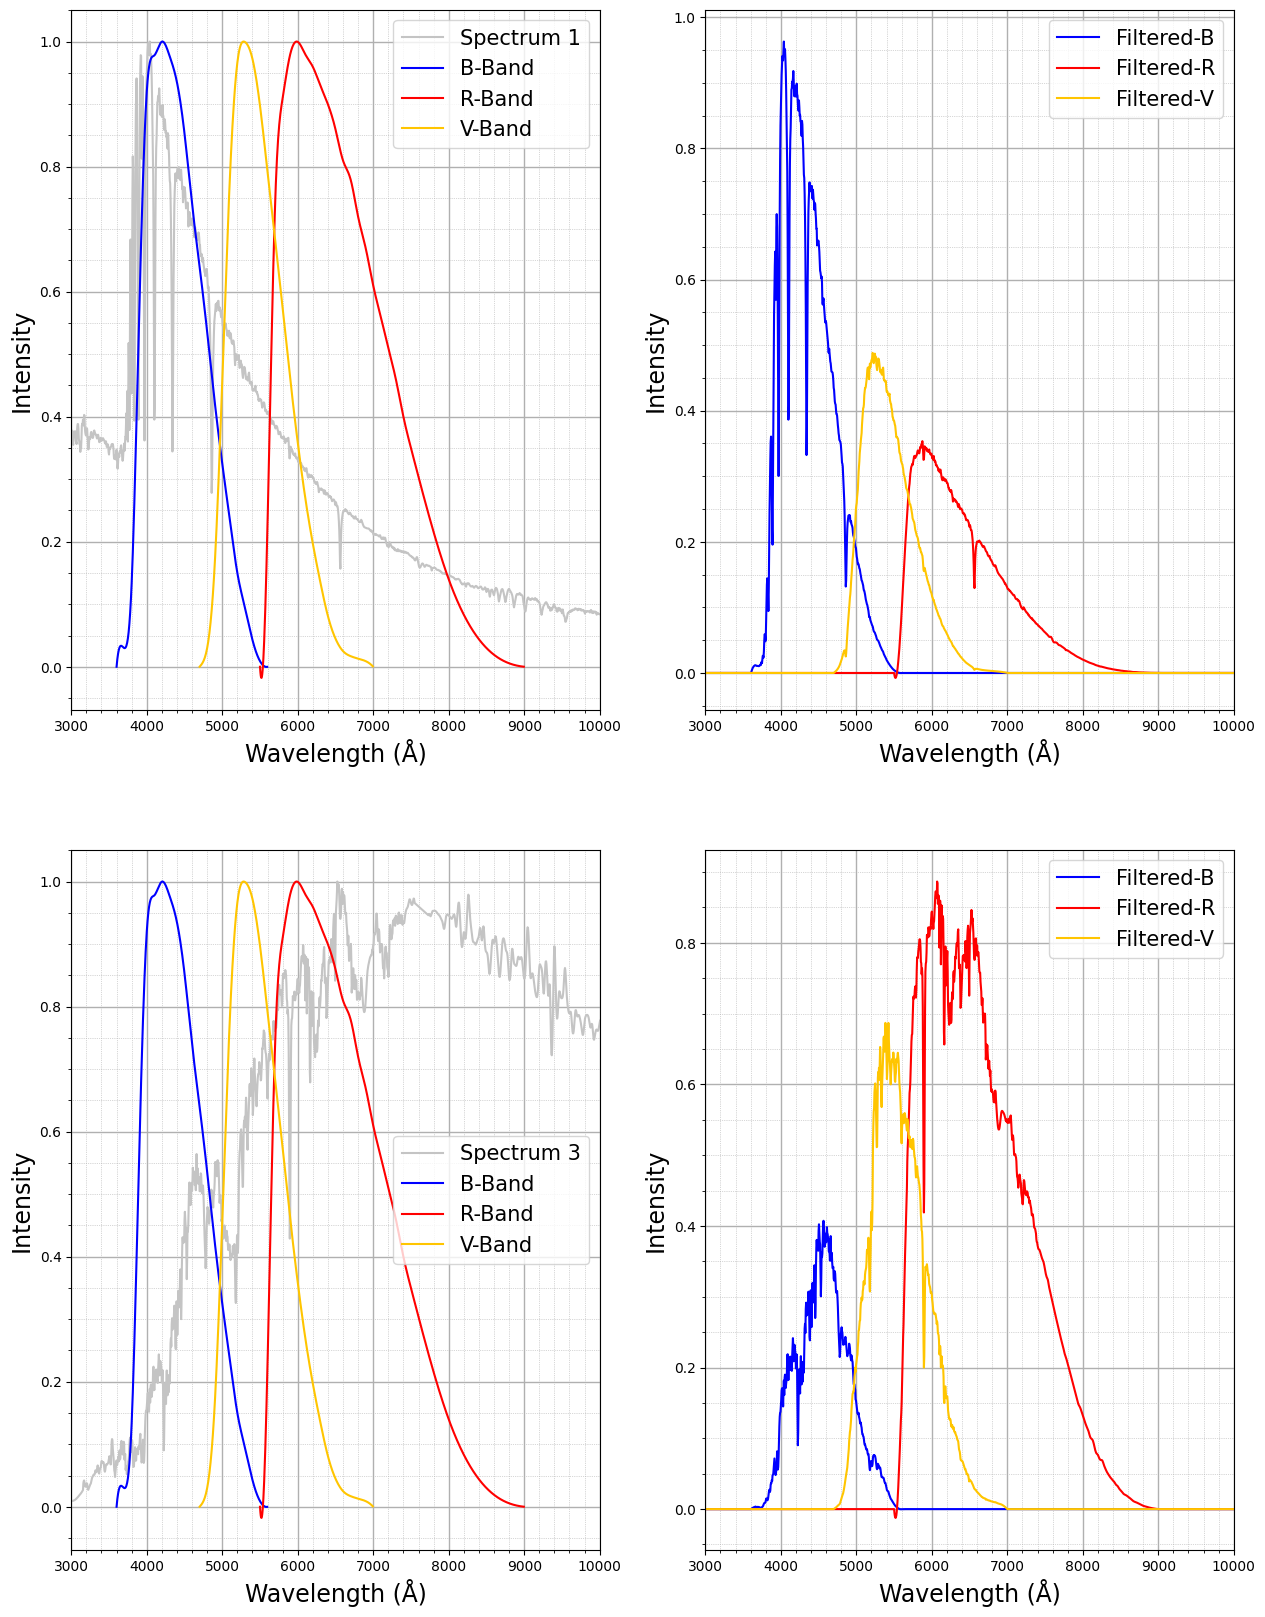

In [41]:
filters = ['filter_B.txt', 'filter_R.txt', 'filter_V.txt']
spectrumA = '1.fits'
spectrumKM = '3.fits'

#Return normalized Spectrum from file
def getSpectrum(spectrum):
    with fits.open(ROOT+PATH+spectrum) as file:
        header = file[0].header
        data = file[0].data
    axis = np.arange(header["CRVAL1"], wavelength_end + header["CDELT1"], header["CDELT1"])
    spectrumData = data
    spectrumData_normalized = np.divide(spectrumData, np.max(spectrumData))
    return axis, spectrumData_normalized

spectrumAxisA, spectrumData_normalizedA = getSpectrum(spectrumA)
spectrumAxisKM, spectrumData_normalizedKM = getSpectrum(spectrumKM)

#Spline Interpolation
def spline(xData, yData):
    tck = splrep(xData, yData)
    xRange = np.arange(min(xData), max(xData), 5)
    return [xRange, splev(xRange, tck)]

#Multiply to spectrum and integrate flux
def apply_filter(spectrum, spectrumData, filter_x, filter_y, filter_axis):
    min_wavelength = min(filter_x)
    max_wavelength = max(filter_x)
    start_index = np.searchsorted(spectrum, min_wavelength, side='left')
    end_index = np.searchsorted(spectrum, max_wavelength, side='right')
    filter_axis[start_index:end_index] = filter_y[:end_index - start_index]
    filtered_spectrum = spectrumData * filter_axis
    integrated_flux = np.trapz(filtered_spectrum, dx=5)
    return filtered_spectrum, integrated_flux

#Calculate Color index (B-V) = calcColorIndex(fluxV, fluxB) etc.
def calcColorIndex(flux, flux2):
    return -2.5 * np.log10(flux2 / flux)


data = []
for file in filters:
    data.append(np.genfromtxt(ROOT+PATH+FILTER+file, dtype=np.float32, names = ['Wavelength','Throughput'], usecols=(0, 1)))

filterWavelengthsB = []
filterValuesB = []
for f in data[0]:
    filterWavelengthsB.append(f[0])
    filterValuesB.append(f[1])

filterWavelengthsR = []
filterValuesR = []
for f in data[1]:
    filterWavelengthsR.append(f[0])
    filterValuesR.append(f[1])

filterWavelengthsV = []
filterValuesV = []
for f in data[2]:
    filterWavelengthsV.append(f[0])
    filterValuesV.append(f[1])

#Wellenlaenge umrechnen und values normieren auf MAX(R)
filterWavelengthsB = np.multiply(filterWavelengthsB, 10000)
filterWavelengthsR = np.multiply(filterWavelengthsR, 10000)
filterWavelengthsV = np.multiply(filterWavelengthsV, 10000)


#Spline interpolation and normalization to MAX(R)
xB, yB = spline(filterWavelengthsB, filterValuesB)
xR, yR = spline(filterWavelengthsR, filterValuesR)
xV, yV = spline(filterWavelengthsV, filterValuesV)

yB = np.divide(yB, np.max(yB))
yR = np.divide(yR, np.max(yR))
yV = np.divide(yV, np.max(yV))


#filter-curve an x-axis anpassen
filterAxisAB = np.zeros_like(spectrumAxisA, dtype=float)
filterAxisAR = np.zeros_like(spectrumAxisA, dtype=float)
filterAxisAV = np.zeros_like(spectrumAxisA, dtype=float)

filterAxisKMB = np.zeros_like(spectrumAxisKM, dtype=float)
filterAxisKMR = np.zeros_like(spectrumAxisKM, dtype=float)
filterAxisKMV = np.zeros_like(spectrumAxisKM, dtype=float)

#filter spectra
filteredSpectrumAB, fluxAB = apply_filter(spectrumAxisA, spectrumData_normalizedA, xB, yB, filterAxisAB)
filteredSpectrumAR, fluxAR = apply_filter(spectrumAxisA, spectrumData_normalizedA, xR, yR, filterAxisAR)
filteredSpectrumAV, fluxAV = apply_filter(spectrumAxisA, spectrumData_normalizedA, xV, yV, filterAxisAV)

filteredSpectrumKMB, fluxKMB = apply_filter(spectrumAxisKM, spectrumData_normalizedKM, xB, yB, filterAxisKMB)
filteredSpectrumKMR, fluxKMR = apply_filter(spectrumAxisKM, spectrumData_normalizedKM, xR, yR, filterAxisKMR)
filteredSpectrumKMV, fluxKMV = apply_filter(spectrumAxisKM, spectrumData_normalizedKM, xV, yV, filterAxisKMV)

#Calc Color Indices
BVA = calcColorIndex(fluxAV, fluxAB)
VRA = calcColorIndex(fluxAR, fluxAV)

BVKM = calcColorIndex(fluxKMV, fluxKMB)
VRKM = calcColorIndex(fluxKMR, fluxKMV)


def addLine(ax, x, y, c='#C4C4C4', label=''):
    ax.plot(x, y, c=c, label=label)
    ax.set_xlabel('Wavelength (Å)', fontsize=17)
    ax.set_ylabel('Intensity', fontsize=17)
    ax.set_xlim([3000, 10000])
    ax.legend(loc='best', fontsize=15)
    ax.minorticks_on()  
    ax.grid(visible=True, which='major', linestyle='-', linewidth=1)
    ax.grid(visible=True, which='minor', linestyle=':', linewidth=0.5)
    return ax


#Plotting
fig, axes = plt.subplots(2, 2, figsize=(15,20))

addLine(axes[0][0], spectrumAxisA, spectrumData_normalizedA, label='Spectrum 1')
addLine(axes[0][0], xB, yB, '#0000FF', 'B-Band')
addLine(axes[0][0], xR, yR, '#FF0000', 'R-Band')
addLine(axes[0][0], xV, yV, '#FFC500', 'V-Band')

addLine(axes[0][1], spectrumAxisA, filteredSpectrumAB, c='#0000FF', label='Filtered-B')
addLine(axes[0][1], spectrumAxisA, filteredSpectrumAR, c='#FF0000', label='Filtered-R')
addLine(axes[0][1], spectrumAxisA, filteredSpectrumAV, c='#FFC500', label='Filtered-V')


addLine(axes[1][0], spectrumAxisKM, spectrumData_normalizedKM, label='Spectrum 3')
addLine(axes[1][0], xB, yB, '#0000FF', 'B-Band')
addLine(axes[1][0], xR, yR, '#FF0000', 'R-Band')
addLine(axes[1][0], xV, yV, '#FFC500', 'V-Band')

addLine(axes[1][1], spectrumAxisKM, filteredSpectrumKMB, c='#0000FF', label='Filtered-B')
addLine(axes[1][1], spectrumAxisKM, filteredSpectrumKMR, c='#FF0000', label='Filtered-R')
addLine(axes[1][1], spectrumAxisKM, filteredSpectrumKMV, c='#FFC500', label='Filtered-V')


print(f'For Spectrum 1(A): \n B-V: {BVA} \n V-R: {VRA} \n\n for Spectrum 3(KM): \n B-V: {BVKM} \n V-R: {VRKM} ')

It is to say,m that the slight bulges at the left sides of the B and R curves result from the used interpolation method, Spline.

